In [ ]:
from google.colab import files
uploaded = files.upload()

Saving historical-data-of-odisha.csv to historical-data-of-odisha.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from datetime import datetime

In [ ]:
path = '/content/historical-data-of-odisha.csv'
df = pd.read_csv(path)

In [ ]:
df = df[6:17]

In [ ]:
df_excluded = df[['Year','GSDP', 'Tourist in Odisha']]

In [ ]:
df_excluded

,Year,GSDP,Tourist in Odisha
6,2009,"14,84,910","65,24,516"
7,2010,"16,29,460","71,51,184"
8,2011,"19,75,300","78,23,953"
9,2012,"23,09,870","85,35,024"
10,2013,"26,17,000","93,57,256"
11,2014,"29,64,750","1,01,31,472"
12,2015,"31,42,500","1,11,23,566"
13,2016,"32,85,500","1,21,35,059"
14,2017,"39,28,040","1,31,90,224"
15,2018,"44,03,950","1,43,64,541"


In [ ]:
df_excluded['Tourist in Odisha'] = df_excluded['Tourist in Odisha'].str.replace(',', '').astype(int)

<ipython-input-104-284d54549605>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['Tourist in Odisha'] = df_excluded['Tourist in Odisha'].str.replace(',', '').astype(int)


In [ ]:
df_excluded['GSDP'] = df_excluded['GSDP'].str.replace(',', '').astype(int)

<ipython-input-105-2442480505f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['GSDP'] = df_excluded['GSDP'].str.replace(',', '').astype(int)


In [ ]:
adf_test = adfuller(df_excluded['GSDP'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: 2.000394531749092
p-value: 0.998673463631577


In [ ]:
df_excluded['GSDP_diff'] = df_excluded['GSDP'].diff().dropna()
df_excluded['Tourist_diff'] = df_excluded['Tourist in Odisha'].diff().dropna()
df_excluded['GSDP_diff2'] = df_excluded['GSDP_diff'].diff().dropna()
df_excluded['Tourist_diff2'] = df_excluded['Tourist_diff'].diff().dropna()

<ipython-input-107-329e195df118>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['GSDP_diff'] = df_excluded['GSDP'].diff().dropna()
<ipython-input-107-329e195df118>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_excluded['Tourist_diff'] = df_excluded['Tourist in Odisha'].diff().dropna()
<ipython-input-107-329e195df118>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
df_diff2 = df_excluded[['GSDP_diff2', 'Tourist_diff2']].dropna()
model = VAR(df_diff2)
lag_order = model.select_order()
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       47.41       47.40   3.911e+20       47.22
1       47.34       47.29   4.066e+20       46.76
2      45.05*      44.98*  7.611e+19*      44.10*
-------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
var_model = model.fit(lag_order.aic)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Jul, 2024
Time:                     11:06:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    44.9751
Nobs:                     7.00000    HQIC:                   44.0973
Log likelihood:          -167.548    FPE:                7.61094e+19
AIC:                      45.0523    Det(Omega_mle):     2.58983e+19
--------------------------------------------------------------------
Results for equation GSDP_diff2
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const              -442909.427123     94967.962832           -4.664           0.000
L1.GSDP_diff2            0.160001         0.194265            0.824           0.410
L1.Tourist_diff2         2.932747         0

In [ ]:
forecast_steps = 30
forecast = var_model.forecast(df_diff2.values[-lag_order.aic:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, columns=['GSDP_diff2', 'Tourist_diff2'])

last_gsdp_diff = df_excluded['GSDP_diff'].iloc[-1]
last_tourist_diff = df_excluded['Tourist_diff'].iloc[-1]

forecast_df['GSDP_diff'] = forecast_df['GSDP_diff2'].cumsum() + last_gsdp_diff
forecast_df['Tourist_diff'] = forecast_df['Tourist_diff2'].cumsum() + last_tourist_diff

last_gsdp = df_excluded['GSDP'].iloc[-1]
last_tourist = df_excluded['Tourist in Odisha'].iloc[-1]

forecast_df['GSDP'] = forecast_df['GSDP_diff'].cumsum() + last_gsdp
forecast_df['Tourist in Odisha'] = forecast_df['Tourist_diff'].cumsum() + last_tourist
forecast_df['Year'] = range(df_excluded['Year'].max() + 1, df_excluded['Year'].max() + 1 + forecast_steps)

df_combined = pd.concat([df_excluded, forecast_df[['Year', 'GSDP', 'Tourist in Odisha']]], ignore_index=True)
print(df_combined)

    Year          GSDP  Tourist in Odisha  GSDP_diff  Tourist_diff  \
0   2009  1.484910e+06       6.524516e+06        NaN           NaN   
1   2010  1.629460e+06       7.151184e+06   144550.0      626668.0   
2   2011  1.975300e+06       7.823953e+06   345840.0      672769.0   
3   2012  2.309870e+06       8.535024e+06   334570.0      711071.0   
4   2013  2.617000e+06       9.357256e+06   307130.0      822232.0   
5   2014  2.964750e+06       1.013147e+07   347750.0      774216.0   
6   2015  3.142500e+06       1.112357e+07   177750.0      992094.0   
7   2016  3.285500e+06       1.213506e+07   143000.0     1011493.0   
8   2017  3.928040e+06       1.319022e+07   642540.0     1055165.0   
9   2018  4.403950e+06       1.436454e+07   475910.0     1174317.0   
10  2019  4.986110e+06       1.562325e+07   582160.0     1258709.0   
11  2020  5.859324e+06       1.688797e+07        NaN           NaN   
12  2021  6.720668e+06       1.828665e+07        NaN           NaN   
13  2022  7.599576e+

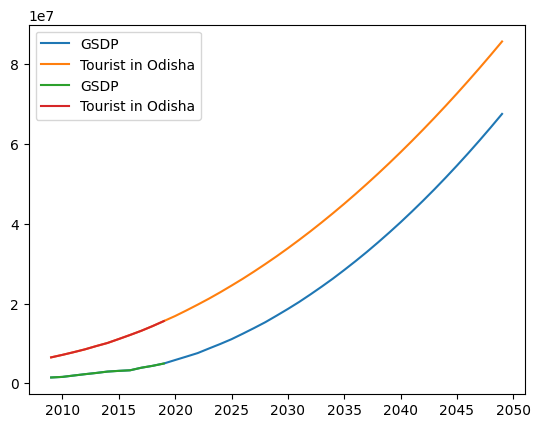

In [ ]:
plt.plot(df_combined['Year'], df_combined['GSDP'], label='GSDP')
plt.plot(df_combined['Year'], df_combined['Tourist in Odisha'], label='Tourist in Odisha')
plt.plot(df_excluded['Year'], df_excluded['GSDP'], label='GSDP')
plt.plot(df_excluded['Year'], df_excluded['Tourist in Odisha'], label='Tourist in Odisha')
plt.legend()